Install Kaggle and Link with Kaggle API Key

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Import Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import HeNormal
import numpy as np
import kaggle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image_dataset_from_directory as Dataset

Load Tensorboard for visualisation

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/ # remove previous runs logs

Download FER 2013

In [ ]:
kaggle.api.authenticate()  # auth with kaggle api
kaggle.api.dataset_download_files('msambare/fer2013', unzip=True) # download and unzip

Load Datasets

In [ ]:
train_set = Dataset(
    'train',
    image_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
    shuffle=True
)

train_set = train_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for images, labels in train_set.take(5):
    print(images.shape)
    print(labels.shape)

In [ ]:
test_set = Dataset(
    'test',
    image_size=(48, 48),
    batch_size=32,
    labels='inferred',
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=False
)

test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Create a Validation Set, Cache and Prefetch

In [ ]:
val_size = int(0.2 * 28709)
val_batches = val_size // 32
val_set = train_set.take(val_batches)
train_set = train_set.skip(val_batches)


val_set = val_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Check Shape of Validation Set

In [ ]:
for images, labels in val_set.take(5):
    print(images.shape)
    print(labels.shape)

Convolutional Block

In [ ]:
def conv_block(x, filters, kernel_size=3, strides=1, padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=HeNormal())(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

CNN Stages

In [ ]:
def cnn(training):

        inputs = tf.keras.Input(shape=(48, 48, 1))

        if training:
          x = layers.RandomFlip(mode='horizontal')(inputs)
          x = layers.RandomRotation(factor=0.1)(x)
          x = layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
          x = layers.RandomZoom(height_factor=(0.2, -0.2))(x)
        else:
          x = inputs

        # Normalisation for all images, do here to avoid it being applied twice and incase augmentation changes the values
        x = layers.Resizing(48, 48)(x)
        x = layers.Rescaling(1./255)(x)

        # Stage 1
        x = conv_block(x, 64)
        x = conv_block(x, 64)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)

        # Stage 2
        x = conv_block(x, 128)
        x = conv_block(x, 128)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)

        # Stage 3
        x = conv_block(x, 256)
        x = conv_block(x, 256)
        x = conv_block(x, 256)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)

        # Stage 4
        x = conv_block(x, 512)
        x = conv_block(x, 512)
        x = conv_block(x, 512)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)

        x = layers.Flatten()(x)

        # Fully Connected Layers
        x = layers.Dense(1024, activation='relu', kernel_initializer=HeNormal())(x)
        x = layers.Dense(512, activation='relu', kernel_initializer=HeNormal())(x)
        x = layers.Dropout(0.4)(x)

        # Output Layer
        outputs = layers.Dense(7, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal())(x)

        # Create Model
        model = models.Model(inputs, outputs)

        # Compile Model
        model.compile(
          optimizer= tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
          loss='categorical_crossentropy',
          metrics=['accuracy']
        )

        return model

Log to Tensorboard

In [ ]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0)

Early Stopping Mechanism

In [ ]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

Learning Rate Scheduler

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=1)

Save Best Weights At High Accuracy Checkpoints

In [ ]:
checkpoint_path = "best.weights.h5"
checkpoint_dir = os.path.dirname('drive/MyDrive/model.weights.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Model Summary

In [ ]:
model = cnn(training=True)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 48, 48, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,421,255 (51.20 MB)

 Trainable params: 13,415,879 (51.18 MB)

 Non-trainable params: 5,376 (21.00 KB)

Training

In [ ]:
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=200,
    callbacks=[tensorboard_callback, lr_scheduler, checkpoint_callback]
)

Load the Logs

In [ ]:
%tensorboard --logdir logs

Load Model Weights, Set training to false and validate test accuracy

In [ ]:
fresh_model = cnn(training=False)
fresh_model.load_weights('drive/MyDrive/model.weights.h5')

loss, acc = fresh_model.evaluate(test_set)
print("Loss: ", loss)
print("Accuracy: ", acc)

fresh_model.save('model.keras')

225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 148ms/step - accuracy: 0.6266 - loss: 1.2104
Loss:  1.1029126644134521
Accuracy:  0.6597937941551208


In [ ]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
all_images = []
all_labels = []

for images, labels in test_set:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

In [ ]:
predictions = fresh_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(all_labels, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 148ms/step


In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Angry       0.55      0.60      0.58       958
     Disgust       0.56      0.57      0.56       111
        Fear       0.54      0.43      0.48      1024
       Happy       0.88      0.86      0.87      1774
     Neutral       0.60      0.60      0.60      1233
         Sad       0.52      0.61      0.56      1247
    Surprise       0.79      0.75      0.77       831

    accuracy                           0.66      7178
   macro avg       0.64      0.63      0.63      7178
weighted avg       0.66      0.66      0.66      7178



In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
cm_normalised = cm.astype('float') / cm.sum(axis=1, keepdims=True)

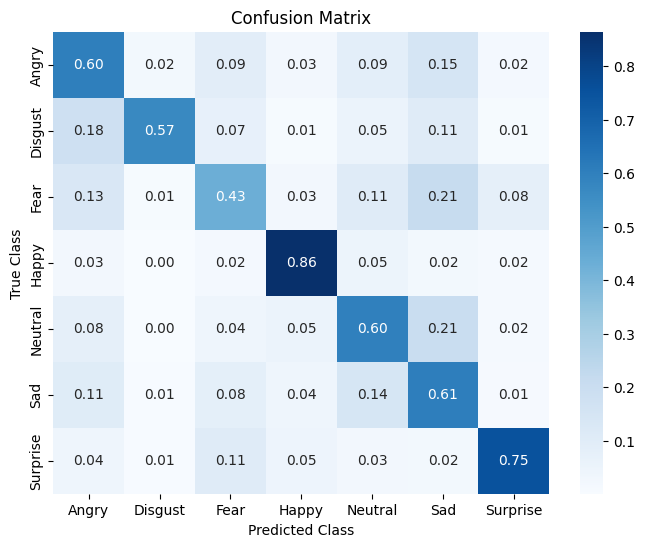

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalised, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

Check Model Loads Successfully

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.keras')

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 38,667,863 (147.51 MB)

 Trainable params: 12,887,495 (49.16 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 25,774,992 (98.32 MB)